In [1]:
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import argparse
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
init_lr = 1e-4  # 0.0001
epochs = 20
bs = 32

In [4]:
mask_path = []
nomask_path = []
incorrectmask_path = []

for filename in os.listdir("/content/drive/MyDrive/cmpe255/dataset/with_mask"):
  mask_path.append(filename)
for filename in os.listdir("/content/drive/MyDrive/cmpe255/dataset/without_mask"):
  nomask_path.append(filename)
for filename in os.listdir("/content/drive/MyDrive/cmpe255/dataset/incorrect_mask"):
  incorrectmask_path.append(filename)

In [5]:
data = []
labels = []

for img in mask_path:

  label = 'with_mask'

  image = load_img("/content/drive/MyDrive/cmpe255/dataset/with_mask/"+img, target_size=(224,224))
  image = img_to_array(image)
  image = preprocess_input(image)

  data.append(image)
  labels.append(label)

for img in nomask_path:

  label = 'without_mask'

  image = load_img("/content/drive/MyDrive/cmpe255/dataset/without_mask/"+img, target_size=(224,224))
  image = img_to_array(image)
  image = preprocess_input(image)

  data.append(image)
  labels.append(label)
    
for img in incorrectmask_path:

  label = 'incorrect_mask'

  image = load_img("/content/drive/MyDrive/cmpe255/dataset/incorrect_mask/"+img, target_size=(224,224))
  image = img_to_array(image)
  image = preprocess_input(image)

  data.append(image)
  labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# New Section

In [6]:
len(labels)

2079

In [7]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# labels = to_categorical(labels)
labels.shape

(2079, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


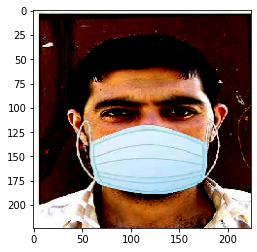

In [8]:
plt.imshow(data[20])

In [9]:
(train_x,test_x,train_y,test_y) = train_test_split(data, labels, test_size = 0.20, stratify = labels, random_state = 42)

In [10]:

train_generator = ImageDataGenerator(
                    rotation_range = 20,
                    zoom_range = 0.15,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.15,
                    horizontal_flip = True,
                    fill_mode="nearest"
                  )

In [11]:
type(train_generator)

tensorflow.python.keras.preprocessing.image.ImageDataGenerator

In [12]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_shape=(224, 224, 3))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = tf.keras.layers.Flatten(name="flatten")(headModel)
headModel = tf.keras.layers.Dense(256, activation="relu")(headModel)
headModel = tf.keras.layers.Dropout(0.25)(headModel)
headModel = tf.keras.layers.Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [13]:
#Complie the model and train it
opt = Adam(lr=init_lr, decay=init_lr / epochs)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
H = model.fit(
	train_generator.flow(train_x, train_y, batch_size=bs),
	steps_per_epoch=len(train_x) // bs,
	validation_data=(test_x, test_y),
	validation_steps=len(test_x) // bs,
	epochs=epochs,
class_weight = {0:5 , 1:1, 2:10})

Epoch 1/20
51/51 [==============================] - 54s 379ms/step - loss: 4.6056 - accuracy: 0.4919 - val_loss: 0.3887 - val_accuracy: 0.8486
Epoch 2/20
51/51 [==============================] - 18s 355ms/step - loss: 1.2868 - accuracy: 0.8597 - val_loss: 0.2361 - val_accuracy: 0.9135
Epoch 3/20
51/51 [==============================] - 18s 356ms/step - loss: 0.7103 - accuracy: 0.9246 - val_loss: 0.1755 - val_accuracy: 0.9351
Epoch 4/20
51/51 [==============================] - 18s 357ms/step - loss: 0.5324 - accuracy: 0.9300 - val_loss: 0.1583 - val_accuracy: 0.9423
Epoch 5/20
51/51 [==============================] - 18s 358ms/step - loss: 0.4251 - accuracy: 0.9553 - val_loss: 0.1195 - val_accuracy: 0.9591
Epoch 6/20
51/51 [==============================] - 18s 358ms/step - loss: 0.3622 - accuracy: 0.9680 - val_loss: 0.1122 - val_accuracy: 0.9591
Epoch 7/20
51/51 [==============================] - 18s 357ms/step - loss: 0.2981 - accuracy: 0.9704 - val_loss: 0.1091 - val_accuracy: 0.9519

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       141
           1       1.00      0.96      0.98       138
           2       0.96      1.00      0.98       137

    accuracy                           0.98       416
   macro avg       0.98      0.98      0.98       416
weighted avg       0.98      0.98      0.98       416



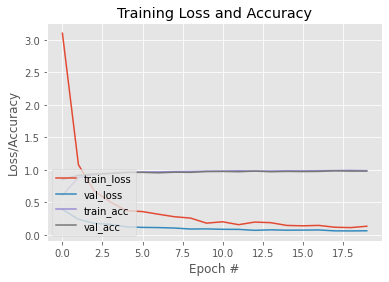

In [14]:
#Evaluate the model again
print("[INFO] evaluating network...")
predIdxs = model.predict(test_x, batch_size=32)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(test_y.argmax(axis=1), predIdxs
	))

# # serialize the model to disk
# print("[INFO] saving mask detector model...")

# plot the training loss and accuracy
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [15]:
model.save("/content/drive/MyDrive/cmpe255/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/cmpe255/assets


In [16]:

model.save("/content/drive/MyDrive/cmpe255/face_detector_model.h5")